# **Coxph trainer - Survival analysis**

The following function provides both [Cox proprotional hazards modelling](https://en.wikipedia.org/wiki/Proportional_hazards_model)
and [Kaplan-Meier](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) plots.

### **Basics of the Cox proportional hazards model**
The purpose of the model is to evaluate simultaneously the effect of several factors on survival.<br> In other words, it allows us to examine how specified factors influence the rate of a particular event happening (e.g., infection, death) at a particular point in time.<br> This rate is commonly referred as the hazard rate ([link](http://www.sthda.com/english/wiki/cox-proportional-hazards-model)).

### **Kaplan-Meier survival estimate**
The Kaplan-Meier (KM) method is a non-parametric method used to estimate the survival probability from observed survival times (Kaplan and Meier, 1958)([link](http://www.sthda.com/english/wiki/survival-analysis-basics)).

### **The function**
train models to predict the timing of events.<br>
Although identical in structure to other training functions, this one
requires generating a 'Y' that represents the age/duration/tenure of
the obervation, designated 'tenure' here, and a binary labels columns that
represents the event of interest, churned/not-churned.<br>
In addition, there is a strata_cols parameter, representing a list of
stratification (aka grouping) variables.

The following example covers:

- [Data exploration](#Data-exploration)
- [Training Cox proprotional hazards and Kaplan-Meier model](#Training-Cox-proprotional-hazards-and-Kaplan-Meier-model)
- - [Importing the function](#Importing-the-function)
- - [Setup function parameters](#Setup-function-parameters)
- - [Running the function locally](#Running-the-function-locally)
- [A peek at a pickled kaplan-meier model](#A-peek-at-a-pickled-kaplan-meier-model)
- [A peek at a pickeld cox hazards default model](#A-peek-at-a-pickeld-cox-hazards-default-model)
- [Some potential default analyses of coxph](#Some-potential-default-analyses-of-coxph)
- - [Running the function remotely](#Running-the-function-remotely)

We will train on [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn) from kaggle, click the link for context.<br>
The dataset is transformed using [one-hot-encoding](https://en.wikipedia.org/wiki/One-hot), check out [customer-churn-prediction demo](https://github.com/mlrun/demos/tree/master/customer-churn-prediction) in the clean_data section for further information.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Make sure the following libraries are installed 
# !pip install lifelines

### **Data exploration**

In [3]:
# Getting raw data as - downloaded from kaggle
import pandas as pd

df = pd.read_csv("https://s3.wasabisys.com/iguazio/data/function-marketplace-data/coxph_trainer/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print('raw dataset')
df.head()

raw dataset


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
df = pd.read_csv("https://s3.wasabisys.com/iguazio/data/function-marketplace-data/coxph_trainer/encoded-data.csv")
print('encoded dataset')
df.head()

encoded dataset


gender  senior  partner  deps  tenure  PhoneService  MultipleLines  \
0       0       0        1     0       1             0              0   
1       1       0        0     0      34             1              0   
2       1       0        0     0       2             1              0   
3       1       0        0     0      45             0              0   
4       0       0        0     0       2             1              0   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                0               0             1                 0   
1                0               1             0                 1   
2                0               1             1                 0   
3                0               1             0                 1   
4                1               0             0                 0   

   TechSupport  StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
0            0            0                0         0                 1   
1            0            0                0         1                 0   
2            0            0                0         0                 1   
3            1            0                0         1                 0   
4            0            0                0         0                 1   

   PaymentMethod  MonthlyCharges  labels  tenure_map  
0              2           29.85       0         0.0  
1              3           56.95       0         2.0  
2              3           53.85       1         0.0  
3              0           42.30       0         3.0  
4              2           70.70       1         0.0

## **Training Cox proprotional hazards and Kaplan-Meier model**

### **Importing the function**

In [16]:
import mlrun
mlrun.set_environment(project='function-marketplace')

fn = mlrun.import_function("hub://coxph_trainer")
fn.image='mlrun/mlrun'
fn.apply(mlrun.auto_mount())

> 2021-10-13 13:22:07,678 [info] loaded project function-marketplace from MLRun DB


### **Setup function parameters**

In [6]:
task = mlrun.new_task(name = "tasks-survive-trainer",
                      params = {"event_column" : "labels", 
                                "strata_cols"  : ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService'],
                                "p_value"      : 0.005,
                                "encode_cols"  : {"Contract"       : "Contract",
                                                  "PaymentMethod"  : "Payment"},
                                "models_dest"  : 'models/cox',
                                "file_ext" : "csv"})

### **Running the function locally**

> 2021-10-13 13:18:36,975 [info] starting run tasks-survive-trainer uid=c525c7402c7e4188b0e22996e8fc682c DB=http://mlrun-api:8080


> 2021-10-13 13:18:41,277 [info] run executed, status=completed


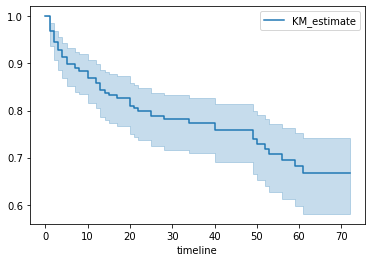

In [7]:
# running the function with the task provided
coxph_run = fn.run(task,
                   local=True,
                   inputs={"dataset"  : "https://s3.wasabisys.com/iguazio/data/function-marketplace-data/coxph_trainer/encoded-data.csv"})

### **A peek at a pickled kaplan-meier model**

In [8]:
# loading the model trained
from mlrun.artifacts import get_model
import pickle
model_file, model_obj, _ = get_model(coxph_run.artifact('km-model'))
model = pickle.load(open(model_file,'rb'))

In [9]:
model.predict([1,10,30,100,200])

1      0.969027
10     0.869452
30     0.781377
100    0.668167
200    0.668167
Name: KM_estimate, dtype: float64

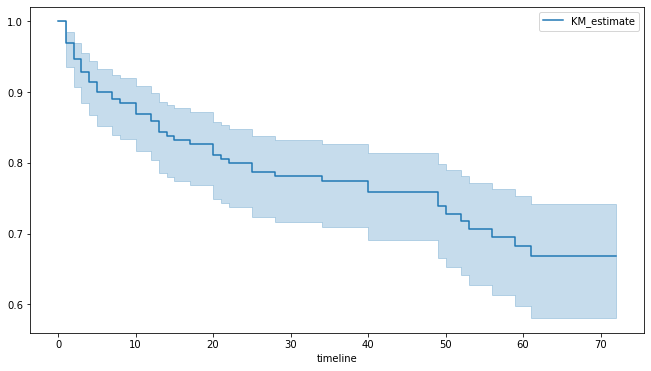

In [10]:
m = model.plot(figsize=(11,6))

### **A peek at a pickeld cox hazards default model**

In [11]:
# loading the model trained
from mlrun.artifacts import get_model
import pickle
model_file, model_obj, _ = get_model(coxph_run.artifact('cx-model'))
model = pickle.load(open(model_file,'rb'))

In [12]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 226 total observations, 171 right-censored observations>
             duration col = 'tenure'
                event col = 'labels'
                   strata = ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']
      baseline estimation = breslow
   number of observations = 226
number of events observed = 55
   partial log-likelihood = -102.57
         time fit was run = 2021-10-13 13:18:38 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
gender             0.71       2.04       0.34             0.04             1.39                 1.04                 4.00
senior            -0.33       0.72       0.44            -1.20             0.54                 0.30                 1.72
partner           -0.39       0.67       0.43            -1.24             0.45                 0.29                 1.57
deps               0.62       1.85       0.50            -0.36             1.59                 0.70                 4.93
MultipleLines     -0.79       0.45       1.09            -2.92             1.34                 0.05                 3.83
OnlineSecurity    -0.77       0.46       1.30            -3.31             1.78                 0.04                 5.93
OnlineBackup      -0.47       0.63       0.95            -2.33             1.39                 0.10                 4.03
DeviceProtection  -0.41       0.66       1.08            -2.54             1.71                 0.08                 5.54
TechSupport        0.51       1.66       1.17            -1.78             2.80                 0.17                16.43
PaperlessBilling   0.35       1.42       0.41            -0.45             1.15                 0.64                 3.16
MonthlyCharges    -0.08       0.92       0.19            -0.46             0.30                 0.63                 1.35
Contract_1        -2.19       0.11       0.71            -3.58            -0.79                 0.03                 0.45
Contract_2       -19.94       0.00    3478.68         -6838.04          6798.16                 0.00                  inf
Payment_1         -0.87       0.42       0.62            -2.07             0.34                 0.13                 1.40
Payment_2          0.46       1.58       0.45            -0.42             1.33                 0.66                 3.80
Payment_3          0.23       1.26       0.64            -1.02             1.49                 0.36                 4.43

                     z      p   -log2(p)
covariate                               
gender            2.08   0.04       4.72
senior           -0.74   0.46       1.13
partner          -0.91   0.36       1.47
deps              1.24   0.22       2.21
MultipleLines    -0.72   0.47       1.09
OnlineSecurity   -0.59   0.56       0.85
OnlineBackup     -0.49   0.62       0.68
DeviceProtection -0.38   0.70       0.51
TechSupport       0.44   0.66       0.59
PaperlessBilling  0.86   0.39       1.35
MonthlyCharges   -0.40   0.69       0.54
Contract_1       -3.07 <0.005       8.88
Contract_2       -0.01   1.00       0.01
Payment_1        -1.41   0.16       2.65
Payment_2         1.03   0.31       1.71
Payment_3         0.36   0.72       0.48
---
Concordance = 0.88
Partial AIC = 237.14
log-likelihood ratio test = 106.72 on 16 df
-log2(p) of ll-ratio test = 48.92

### **Some potential default analyses of coxph**

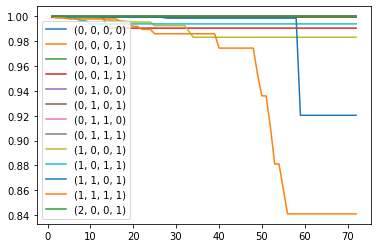

In [13]:
model.baseline_survival_.plot()

* run the following for each of the lines that passes some test (p < 0.005,for example):<br>
 `model.plot_covariate_groups('Contract_1', values=[0, 1]);`<br>
 the plot needs to have the strata decoded
 
 In the train_model above, set param `plot_cov_groups=True` and produce the following set of artifacts by selecting only those covariates whose p-values
 are below some threshold `p_value`

### **Running the function remotely**


In [14]:
fn.spec.build.commands=['pip install lifelines']
fn.deploy(with_mlrun=False)

> 2021-10-13 13:18:42,095 [info] Started building image: .mlrun/func-default-coxph-trainer:latest
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0001] Executing 0 build triggers                   
INFO[0001] Unpacking rootfs as cmd RUN pip install lifelines requires it. 
INFO[0015] RUN pip install lifelines                    
INFO[0015] Taking snapshot of full filesystem...        
INFO[0026] cmd: /bin/sh                                 
INFO[0026] args: [-c pip install lifelines]             
INFO[0026] Running: [/bin/sh -c pip install lifelines]  
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=5211d5dddff0a9102583375dc2c468962b66b424d3fc0c75437b2d2f0d7e2576
  Stored in directory: /tmp/pip-eph

True

In [15]:
coxph_run = fn.run(task,
                   local=False,
                   inputs={"dataset"  : "https://s3.wasabisys.com/iguazio/data/function-marketplace-data/coxph_trainer/encoded-data.csv"})

> 2021-10-13 13:19:41,275 [info] starting run tasks-survive-trainer uid=8b4ee122120645be9eb29a646ef6e562 DB=http://mlrun-api:8080
> 2021-10-13 13:19:41,455 [info] Job is running in the background, pod: tasks-survive-trainer-swjkk
> 2021-10-13 13:19:50,461 [info] run executed, status=completed

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Column Contract_2 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['labels'].astype(bool)
>>> print(df.loc[events, 'Contract_2'].var())
>>> print(df.loc[~events, 'Contract_2'].var())

A very low variance means that the column Contract_2 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-

> 2021-10-13 13:19:50,645 [info] run executed, status=completed


[Back to the top](#Coxph-trainer---Survival-analysis)